In [1]:
#순차적인 데이터를 처리하는 RNN
#데이터의 순서가 주는 정보까지 인지해내는 새로운 신경망을 배워보자 !

#현실의 배부분의 경험은 순차적임 (sequential)
#시계열 데이터의 정보를 받아서 전체 내용을 학습할 수 있음
#RNN은 시계열 데이터의 정보를 하나씩 입력 받을 때 마다 지금까지 입력된 벡터들을 종합해 은닉벡터를 만들어냄
#IMDB를 사용하여 영화리뷰 5만건 긍정적인 리뷰인지 부정적인 리뷰인지 테스트해보기
#토큰화 하여 입력된 정보를 각각의 벡터로 나타내준다. (word embedding)


In [2]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
# torchtext 버전상의 문제로 rnn은 건너뛰고 seq2seq모델로 예제를 하고 rnn파트를 마무리지음
# seq2seq 모델은 각자 다른 역할을 하는 두개의 rnn을 이어붙인 모델로 
# 이해를 하는 part와 다른 언어로 적어나가는 part 두개로 구분되며 이를 인코더 디코더라고 한다
# 인코더에서는 모든 단어를 입력 받아 문장의 뜻을 내포하는 하나의 고정크기 텐서를 만들어냄
# 이 텐서는 원문의 뜻과 내용을 압축하고 있다고 하여 문맥벡터라고 한다.


In [3]:
#기존의 번역을 할 때는 문장을 번역하므로 토큰을 사용하지만, 이 예제에서는 단어를 번역할 것이므로 글자단위의 캐릭터 임베딩을 사용함
# 데이터셋 속에 총 몇종류의 토큰이 있는지 정의해주는 변수 선언
vocab_size = 256 # 총 아스키 코드 개수
# 모델에 입력될 원문과 번역문을 아스키 코드의 배열로 정의하고 텐서로 바꿔준다
x_ = list(map(ord,'hello'))#아스키 코드로 변환
y_ = list(map(ord,'hola'))#아스키 코드로 변환
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
#seq2seq 모델 클래스 정의
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq,self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        #다음 임베딩 함수를 정의해줌
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        #마지막으로 디코더가 번역문의 다음 토큰을 예상해내는 작은 신경망 만들어줌
        self.project = nn.Linear(hidden_size,vocab_size)
        #이렇게 객체들을 선언하고 forward 함수 만들어주기
    def forward(self, inputs, targets):
        initial_state = self._init_state()# 첫번째 은닉벡터
        embedding = self.embedding(inputs).unsqueeze(1)# encoder에 입력되는 원문을 구성하는 모든 문자들을 임베딩
        #인코더에 입력시켜서 encoder state를 만든 다음 이 벡터를 디코더의 첫번째 은닉벡터인 decoder_state로 지정함
        #디코더가 번역문의 첫 번째 토큰을 예상하려면 인코더의 문맥벡터와 문장 시작 토큰을 입력 데이터로 받아야함
        #문장 시작 토큰은 실제로 문장에 나타나진 않지만 디코더가 정상적으로 작동할 수 있도록 인위적으로 넣은 토큰임
        encoder_output, encoder_state = self.encoder(embedding,initial_state)
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0]) #문장 시작 토큰 아스키코드 0
        outputs = []
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output , decoder_state = self.decoder(decoder_input,decoder_state)
            #디코더의 결과값은 다시 디코더 모델에 입력됨
            #디코더의 출력값이 신경망의 마지막 층인 softmax층을 거치면 번역문의 다음 예상 글자가 나옴
            #이 예상 결과를 output에 넣어서 오차를 계산할때 쓸 예정
            projection = self.project(decoder_output)
            outputs.append(projection)
            #데이터가 풍부하다면 디코더가 예측한 토큰을다음 반복에서 입력될 토큰으로 갱신해주는 것이 정석임
            #하지만 학습이 아직 되지 않은 상태의 모델은 잘못된 예측을 할 가능성이 높음
            #이럴때는 학습속도가 저하될 수 있으니 이를 예방하기 위해 티처포싱을 사용함(teacher forcing)
            
            #티처포싱은 디코더 학습 시 실제 번역문의 토큰을 디코더의 전 출력값대신 사용하여 학습을 가속화시킴 
            #번역문의 i번째 토큰에 해당하는 값 targets[i]를 디코더의 입력값으로 사용함
            #티처포싱을 이용한 디코더 입력 갱신 
            decoder_input = torch.LongTensor([targets[i]])
        outputs = torch.stack(outputs).squeeze()
        return outputs
    def _init_state(self,batch_size = 1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers,batch_size,self.hidden_size).zero_()
    #모델 구형 종료
    


 반복: 0 오차: 5.6100239753723145
['\x0b', 'Ó', 'ÿ', 'Ï']

 반복: 100 오차: 1.8516188859939575
['o', 'o', 'l', 'a']

 반복: 200 오차: 0.662935733795166
['h', 'o', 'l', 'a']

 반복: 300 오차: 0.42184799909591675
['h', 'o', 'l', 'a']

 반복: 400 오차: 0.2811207175254822
['h', 'o', 'l', 'a']

 반복: 500 오차: 0.1958523690700531
['h', 'o', 'l', 'a']

 반복: 600 오차: 0.14717136323451996
['h', 'o', 'l', 'a']

 반복: 700 오차: 0.1157865896821022
['h', 'o', 'l', 'a']

 반복: 800 오차: 0.0923457220196724
['h', 'o', 'l', 'a']

 반복: 900 오차: 0.06327039003372192
['h', 'o', 'l', 'a']


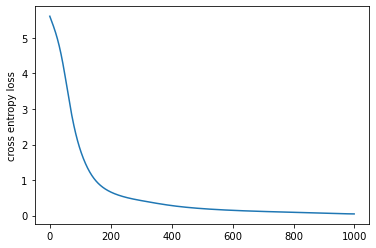

In [8]:
#다음으로 학습을 시작하기 전에 마지막으로 교차 엔트로피 오차를 구하는 crossentropyloss클래스와 최적화 알고리즘을 정의함
seq2seq = Seq2Seq(vocab_size,16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(),lr=1e-3)
#이제 1000번의 epoch에 걸쳐서 모델을 학습시킴
log = []
for i in range(1000):
    prediction = seq2seq(x,y)
    loss = criterion(prediction,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복: %d 오차: %s" % (i,loss_val.item()))
        _,top1 = prediction.data.topk(1,1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])

plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()